In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
# Load dataset (replace with actual path)
sensor_df = pd.read_csv("/content/sensor_df10m_final.csv")

In [3]:
sensor_df.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
0,26/05/21 13:00,119.993750,104.962500,59.993750,47.500000,0.881875
1,26/05/21 13:10,120.020540,97.928895,59.969136,47.507397,0.864791
2,26/05/21 13:20,120.019424,97.775872,59.960309,47.523690,0.864258
3,26/05/21 13:30,120.016662,97.750659,59.966538,47.540000,0.864011
4,26/05/21 13:40,120.026570,98.090260,59.971062,47.555500,0.865002


In [4]:
sensor_df.tail()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
16749,19/09/21 20:30,120.106544,82.294073,59.968158,279.843839,0.939858
16750,19/09/21 20:40,120.109373,82.175063,59.977823,279.856544,0.940176
16751,19/09/21 20:50,120.102829,82.245620,59.960251,279.869657,0.940463
16752,19/09/21 21:00,120.099079,82.231845,59.954815,279.884679,0.940479
16753,19/09/21 21:10,120.103253,82.027681,59.973571,279.894327,0.940265


In [5]:
# Convert Server_Date to datetime format
sensor_df["Server_Date"] = pd.to_datetime(sensor_df["Server_Date"], format="%d/%m/%y %H:%M")

In [6]:
sensor_df.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor
0,2021-05-26 13:00:00,119.993750,104.962500,59.993750,47.500000,0.881875
1,2021-05-26 13:10:00,120.020540,97.928895,59.969136,47.507397,0.864791
2,2021-05-26 13:20:00,120.019424,97.775872,59.960309,47.523690,0.864258
3,2021-05-26 13:30:00,120.016662,97.750659,59.966538,47.540000,0.864011
4,2021-05-26 13:40:00,120.026570,98.090260,59.971062,47.555500,0.865002


In [7]:
# Sort by datetime
sensor_df = sensor_df.sort_values("Server_Date").reset_index(drop=True)

In [8]:
# Creating lag features
for i in range(1, 6):  # Previous 5 records
    sensor_df[f'Power_Lag_{i}'] = sensor_df['Power'].shift(i)

In [9]:
# Drop initial rows with NaN values due to lagging
sensor_df = sensor_df.dropna().reset_index(drop=True)

In [10]:
# Prepare features and target
features = [f'Power_Lag_{i}' for i in range(1, 6)]
target = 'Power'
X = sensor_df[features]
y = sensor_df[target]

In [11]:
sensor_df.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor,Power_Lag_1,Power_Lag_2,Power_Lag_3,Power_Lag_4,Power_Lag_5
0,2021-05-26 13:50:00,120.014958,100.133034,59.955999,47.572402,0.868939,98.090260,97.750659,97.775872,97.928895,104.962500
1,2021-05-26 14:00:00,120.013385,101.921487,59.979209,47.590333,0.871793,100.133034,98.090260,97.750659,97.775872,97.928895
2,2021-05-26 14:10:00,119.937979,115.386556,59.964073,47.606500,0.893724,101.921487,100.133034,98.090260,97.750659,97.775872
3,2021-05-26 14:20:00,120.025351,102.378651,59.977968,47.624500,0.871896,115.386556,101.921487,100.133034,98.090260,97.750659
4,2021-05-26 14:30:00,120.042531,95.869542,59.975539,47.642278,0.859527,102.378651,115.386556,101.921487,100.133034,98.090260


# Power Prediction using Random Forest Regressor

In [12]:
# Train forecasting model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [13]:
# Make predictions
sensor_df['Predicted_Power'] = model.predict(X)

# Anomaly Detection using Autoencoder

In [23]:
!pip install tensorflow

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from scipy.stats import zscore

In [25]:
# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(sensor_df[['Predicted_Power']])

In [26]:
# Autoencoder Model
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_layer, decoded)

In [27]:
# Compile & Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, shuffle=True, verbose=0)

In [28]:
# Anomaly Score = Reconstruction Error
reconstructed = autoencoder.predict(X_scaled)
error = ((X_scaled - reconstructed) ** 2).mean(axis=1)

524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [29]:
# Threshold for anomalies (e.g., 95th percentile)
threshold = np.percentile(error, 95)
sensor_df['Anomaly'] = ['Yes' if e > threshold else 'No' for e in error]

In [30]:
sensor_df.head()

,Server_Date,Voltage,Power,Frequency,Energy,Power_Factor,Power_Lag_1,Power_Lag_2,Power_Lag_3,Power_Lag_4,Power_Lag_5,Predicted_Power,Anomaly,Anomaly_Score
0,2021-05-26 13:50:00,120.014958,100.133034,59.955999,47.572402,0.868939,98.090260,97.750659,97.775872,97.928895,104.962500,99.333296,No,0.245133
1,2021-05-26 14:00:00,120.013385,101.921487,59.979209,47.590333,0.871793,100.133034,98.090260,97.750659,97.775872,97.928895,104.203112,No,0.175389
2,2021-05-26 14:10:00,119.937979,115.386556,59.964073,47.606500,0.893724,101.921487,100.133034,98.090260,97.750659,97.775872,110.523682,No,0.306909
3,2021-05-26 14:20:00,120.025351,102.378651,59.977968,47.624500,0.871896,115.386556,101.921487,100.133034,98.090260,97.750659,107.121205,No,0.193128
4,2021-05-26 14:30:00,120.042531,95.869542,59.975539,47.642278,0.859527,102.378651,115.386556,101.921487,100.133034,98.090260,97.778530,No,0.318516


In [32]:
# Print records which are anomalies
sensor_df[sensor_df['Anomaly'] == 'Yes'][['Server_Date', 'Power', 'Predicted_Power', 'Anomaly', 'Anomaly_Score']]

,Server_Date,Power,Predicted_Power,Anomaly,Anomaly_Score
2039,2021-06-09 17:40:00,164.402306,144.263816,Yes,-0.009401
6193,2021-07-08 14:00:00,4.869326,4.870501,Yes,0.186605
6198,2021-07-08 14:50:00,4.869684,4.871107,Yes,0.183567
6209,2021-07-08 16:40:00,4.867791,4.869361,Yes,0.190470
6210,2021-07-08 16:50:00,4.872180,4.871210,Yes,0.182823
...,...,...,...,...,...
10207,2021-08-05 11:00:00,0.000000,0.013459,Yes,0.030741
10208,2021-08-05 11:10:00,0.000000,0.000000,Yes,0.030741
10209,2021-08-05 11:20:00,0.000000,0.070646,Yes,0.030741
10210,2021-08-05 11:30:00,0.000000,0.264923,Yes,0.030741


In [34]:
sensor_df[['Server_Date', 'Power', 'Predicted_Power', 'Anomaly', 'Anomaly_Score']]

,Server_Date,Power,Predicted_Power,Anomaly,Anomaly_Score
0,2021-05-26 13:50:00,100.133034,99.333296,No,0.245133
1,2021-05-26 14:00:00,101.921487,104.203112,No,0.175389
2,2021-05-26 14:10:00,115.386556,110.523682,No,0.306909
3,2021-05-26 14:20:00,102.378651,107.121205,No,0.193128
4,2021-05-26 14:30:00,95.869542,97.778530,No,0.318516
...,...,...,...,...,...
16744,2021-09-19 20:30:00,82.294073,82.207404,No,0.223545
16745,2021-09-19 20:40:00,82.175063,82.136798,No,0.223545
16746,2021-09-19 20:50:00,82.245620,82.170791,No,0.223545
16747,2021-09-19 21:00:00,82.231845,82.248152,No,0.223997


# Evaluation Metrics

## MSE, MAE, RMSE, R-squared

In [54]:
mse = mean_squared_error(X_scaled, reconstructed)
mae = mean_absolute_error(X_scaled, reconstructed)
rmse = np.sqrt(mse)
r2 = r2_score(X_scaled, reconstructed)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R-Squared Score): {r2:.6f}")

# Save Anomaly Scores
sensor_df['Anomaly_Score'] = error

# Define Anomaly Labeling based on 95th percentile threshold
threshold = np.percentile(error, 95)
sensor_df['Anomaly_Predicted'] = ['Yes' if e > threshold else 'No' for e in error]

y_true = (sensor_df['Anomaly'] == 'Yes').astype(int)
y_pred = (sensor_df['Anomaly_Predicted'] == 'Yes').astype(int)

Mean Squared Error (MSE): 0.000406
Mean Absolute Error (MAE): 0.013503
Root Mean Squared Error (RMSE): 0.020145
R-squared (R-Squared Score): 0.989862


In [44]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15911
           1       1.00      1.00      1.00       838

    accuracy                           1.00     16749
   macro avg       1.00      1.00      1.00     16749
weighted avg       1.00      1.00      1.00     16749



In [45]:
# Confusion Matrix
print("\nConfusion Matrix:")
confusion_matrix(y_true, y_pred)


Confusion Matrix:


array([[15911,     0],
       [    0,   838]])

In [47]:
# AUC-ROC Score
auc_roc = roc_auc_score(y_true, y_pred)
f"AUC-ROC Score: {auc_roc:.6f}"

'AUC-ROC Score: 1.000000'

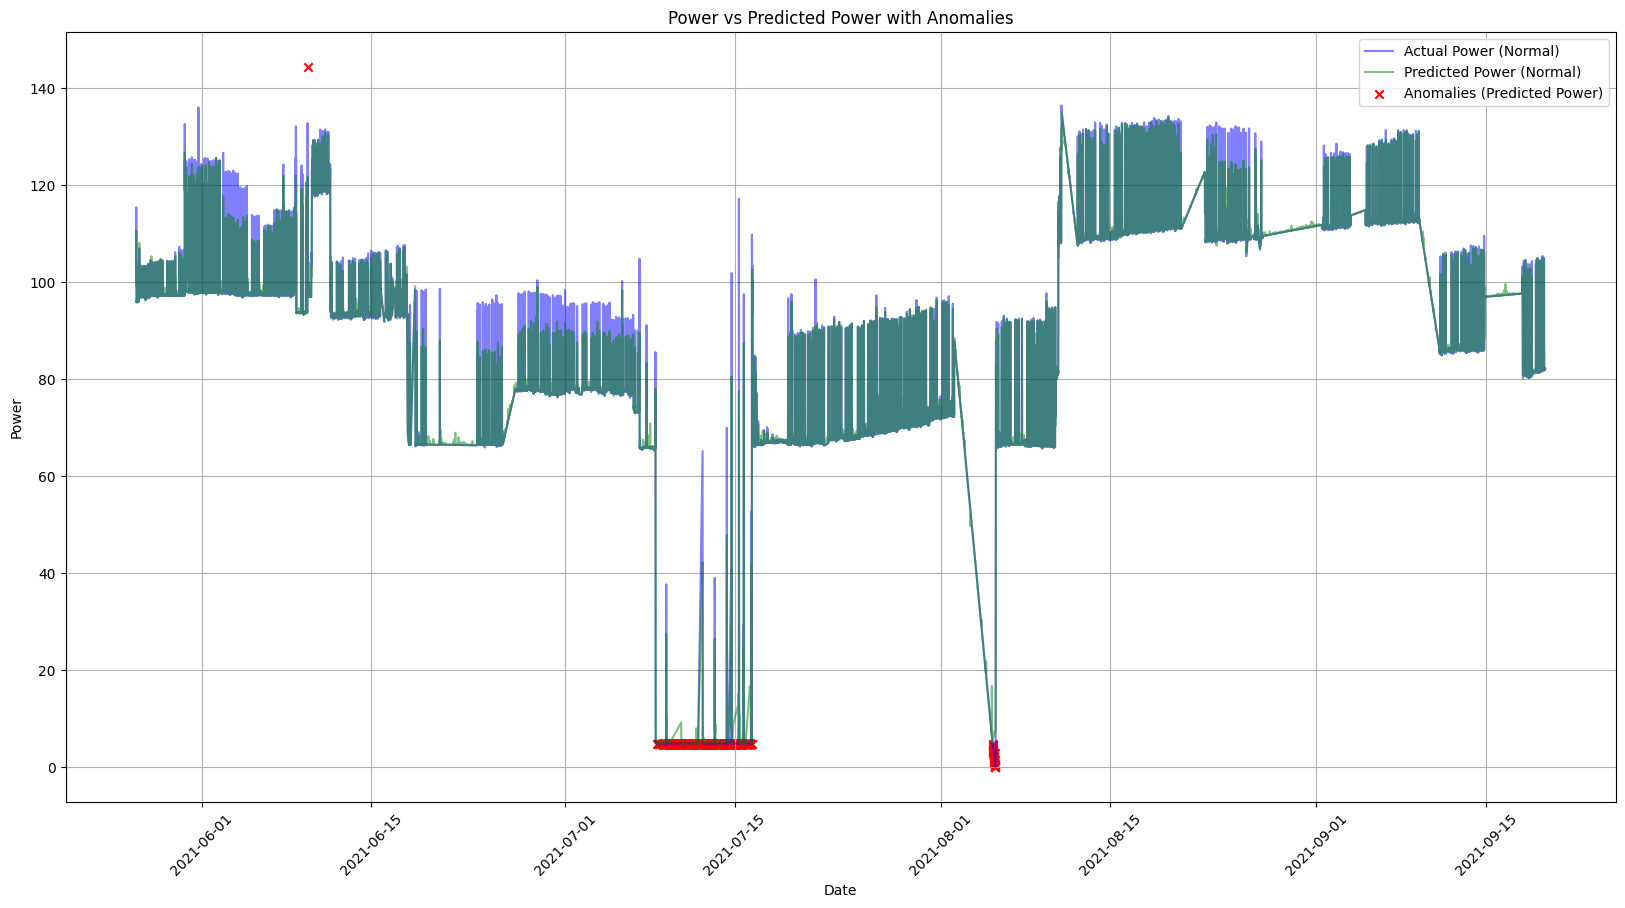

In [51]:
# Separate anomalies and normal points
anomalies = sensor_df[sensor_df['Anomaly'] == 'Yes']
normal_data = sensor_df[sensor_df['Anomaly'] == 'No']

plt.figure(figsize=(20, 10))

# Plot normal data in blue
plt.plot(normal_data['Server_Date'], normal_data['Power'], label='Actual Power (Normal)', color='blue', alpha=0.5)
plt.plot(normal_data['Server_Date'], normal_data['Predicted_Power'], label='Predicted Power (Normal)', color='green', alpha=0.5)

# Plot anomalies in red
plt.scatter(anomalies['Server_Date'], anomalies['Predicted_Power'], color='red', label='Anomalies (Predicted Power)', marker='x')

# Labels & Legend
plt.xlabel('Date')
plt.ylabel('Power')
plt.title('Power vs Predicted Power with Anomalies')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()